# Jan Rybak Benetka 

- - -

``` Hi, my name is Jan and I'd like to join the Etsy data crew, even just for a while ;-)```


- - -

``` - About - ```  
- - -


<img src="http://www.rybak.io/wp-content/uploads/2015/05/janryb_500px-BW-round.png"  width="120px" align="right" /> 
To quickly introduce myself, I'm from the Czech Republic, doing PhD at <a href="http://www.ntnu.edu/">NTNU</a> in Norway, currently visiting <a href="http://www.ntu.edu.sg/">NTU</a> in Singapore. Apart from working with data, I love cycling, traveling, coffee and photography. I'm also a big fan of craft, personally, I design <a href="http://www.bohemiacycles.com/">cycling jerseys</a> together with a friend of mine.

You'll find more about me at <a href="http://www.rybak.io">www.rybak.io</a>.

- - -

``` - Research - ```    
- - -

In short, I'm focused on profiling entities such as people, locations or companies. It means that I try to find and extract information that somehow defines the entities. I'm also interested in presentation of such information - i.e., when 
and how it should be served to users. 

In my latest paper (will appear at WSDM'17), I analyzed the latter problem with the mobile intelligent assistant such as Google Now/Siri in mind and I proposed a model which anticipates information needs (e.g., bus timetable, map, menu) of people based on their activity in order to serve appropriate information cards before the users even realize they need some infromation  (pro-active information retrieval).     

In my previous work, I studied expertise of people and how it changes over time. I focused on researchers and defined  possible career evolution paths - specialization in the filed, broadening of expertise, switching topics, etc. 

At the moment I'm working on inference of entity attributes from a social network, using attributed graph models.

- - -

``` - Why you want me & why I want you - ```    
- - -

-  First of all, **I like Etsy's mission**. In my eyes it is exactly opposite to what other companies are doing. Instead of unifying and globalization, you promote originality. That's why I buy presents via Etsy and that's also the reason I design my own cycling jerseys - I appreciate uniqueness.

 - **I'm doing a PhD** in Information Retrieval / Data Mining field.

- In **my current project**, I'm developing semi-supervised (graph) methods for infering missing details about venues on Foursquare. In Etsy, this could be used for automatic suggestion of product attributes, for instance.

- You have lots of entities and I'm interested in **entities - their profiling, temporal evolution, presentation,...**

 - I like to work with **Python** and its data-related packages (**scipy**, **numpy**, **networkx**), I use **Jupyter Notebook** a lot, I also use **Spark**.

 - I like to quickly **sketch ideas**, create **mock-ups** and **visualize results**.

 - I'd like to work on algorithms that are **applied in production**, study the feedback and get insights about your audience.

 - I like to **learn** new things, especially from people around.

 - I **teach** students / **lecture** stuff and I enjoy that, even though I'm often nervous :)

- I **bike to work**.

 - I have a lot of **questions** about Etsy.

 - I like **good design**, nice **<a href="http://www.slideshare.net/jendarybak">presentations</a>** & visualizations.

- - -

``` - Fun with Etsy data - ```    
- - -

# Reviews analysis

Instead of writing more text about me, I've decided to perform a quick&dirty analysis   
of data during the weekend, hopefully you'll find it more interesting. I'll look at user         
reviews of 7 (my lucky number) sellers and see if I can find something interesting.  

- - -

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import requests
import difflib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter
from bs4 import BeautifulSoup

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Global variables

In [3]:
# load the review pages only once & store them here
pages_dir = './data/pages/'

# output pandas dataframe 
reviews_df_file = './data/reviews_df.p'

# quazi-randomly selected sellers
sellers = ['DeskTopPeloton','EarthArtAustralia','ArtPrintsVicky',
           'Markfabric','treesizeverse','oopsmark','Nanogramstore']

#### Functions

Functions for gentle scraping of reviews ;-)

In [4]:
def scrape_reviews(seller, page):
    """
    Issues a request for a website 
    with seller's reviews on a given page.
    """
    base_url = 'https://www.etsy.com/shop/' + seller + '/reviews'
    my_params = {'ref': 'pagination', 'page': page}
    return requests.get(base_url, params = my_params)

In [5]:
def scrape_reviews_local(seller, page):
    """
    Returns html code of saved webpages 
    instead of issuing requests to the server.
    """
    
    class Response:
        def __init__(self, url, text):
            self.url = url
            self.text = text
    
    try:
        with open(pages_dir + seller + '_' +  str(page) + '.html') as rf:
            return Response('', rf.read())
    except:
        return Response('ref=a-review-too-far', '')

In [6]:
def parse_reviews(response_text):
    """
    Given source of an HTML document, 
    parses and returns a list with reviews, 
    each review is a dictionary.
    """
    
    reviews = []
    soup = BeautifulSoup(response_text, 'html.parser')
    
    shop = soup.find('h2', class_='condensed-header-shop-title').find(class_='show-xs').text.strip()
    location = soup.find(class_='ss-location').findNext('div').find(class_='show-xs').text.strip()
    shop_img = soup.find('img', class_='rounded')['src']

    for rw in soup.find_all('div', class_='review-item'):

        rw_tmp = {} # keeps data of 1 review

        try:
            
            # information about seller
            rw_tmp['shop'] = shop
            rw_tmp['location'] = location
            rw_tmp['shop_img'] = shop_img
            
            # information about product + review
            rw_tmp['text'] = rw.find(class_='prose').text
            rw_tmp['name'], rw_tmp['date'] = [string.strip() for string in rw.find(class_='mt-xs-2').find('p').text.rsplit(' on ')]
            rw_tmp['rating'] = rw.find(attrs={'name': 'rating'})['value'].strip()
            rw_tmp['product_title'] = rw.find('a', class_='card-body')['title'].strip()
            rw_tmp['product_url'] = rw.find('a', class_='card-body')['href'].strip()
            rw_tmp['product_img'] = rw.find('img', class_='listing-image')['src'].strip()

            reviews.append(rw_tmp)    
        except:
            continue # for simplicity of this demo, skip in case of a problem

    return reviews

Plotting functions

In [7]:
def plot_sorted_counter(counter, xlabel, ylabel, yscale='linear', title=None, rotation=0):
    """
    Accepts 'Counter' object and plots as a bar chart.
    """
    x_values = range(0, len(counter))
    y_values = [c[1] for c in counter]
    labels = [c[0] for c in counter]

    # how to horizontaly align x-labels 
    ha = 'center' if rotation==0 else 'right'
    
    plt.figure(figsize=(16, len(counter)*0.2))
    plt.bar(x_values, y_values, align='center', linewidth=1, fill=True, facecolor='pink', color='black',  hatch='/////')
    plt.xticks(x_values, labels, rotation=rotation, ha=ha)
    if(title): plt.title(title, fontsize=16, y=1.04)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    ax = plt.gca()
    ax.grid(b=True, which='major', linestyle='-', color='#edeff2')    
    ax.set_axisbelow(True)
    
    plt.yscale(yscale)
    plt.margins(0.01)

In [8]:
def plot_boxplot(data_df, x_axis, y_axis, data_order):
    sns.set(style="ticks", palette="muted", color_codes=True)

    plt.figure(figsize=(10,40))

    # plot a boxplot
    ax = sns.boxplot(x=x_axis, y=y_axis, data=data_df, 
                     whis=np.inf, linewidth=1, order=data_order, showmeans=True, meanline=True,
                     palette=sns.diverging_palette(220, 10, sep=155, n=len(data_order)))

    # Add observation points
    sns.stripplot(x=x_axis, y=y_axis, data=data_df, order=data_order,
                  jitter=False, size=3, color="0.1", linewidth=0)

    # Adjust axes
    ax.grid(b=True, which='major', color='#edeff2')
    ax.tick_params(labelbottom='on',labeltop='on')
    ax.xaxis.set_label_position('top')
    sns.despine(bottom=False, top=False, left=True, right=True)

In [9]:
def plot_cat_counter(y_values, x_values, gs_specs):
    """
    Accepts two y and x values (lists) and Gridspec definition.
    Plots horizontal bars in reversed order (first value on top).
    """
    
    labels = y_values
    y_values = list(range(len(y_values)))
    
    # reverse values
    labels = labels[::-1]
    x_values = x_values[::-1]
    
    plt.subplot(gs_specs)
    plt.barh(y_values, x_values, align='center', linewidth=1, fill=True, 
             facecolor='pink', color='black',  hatch='/////')
    plt.yticks(y_values, labels)
    plt.grid(True)
    ax = plt.gca()
    ax.grid(b=True, which='major', linestyle='-', color='#edeff2')    
    ax.set_axisbelow(True)
    plt.margins(0.01)

In [10]:
def plot_cat_polarity(counter, gs_specs):
    """
    Accepts counter with sentiment polarities and their counts and Gridspec definition.
    Plots vertical bars representing sentiment in range <-1,1>.
    """
    
    POSITIVE_COLOR = '#4c7a88'
    NEGATIVE_COLOR = '#c44f59'
    
    # define empty values
    if(len(counter) > 0):
        x_values = list(counter.keys())
        y_values = list(counter.values())
    else:
        x_values = []
        y_values = []

    # positive: green,  negative: red
    colors = [NEGATIVE_COLOR if val < 0 else POSITIVE_COLOR for val in counter.keys()]

    labels = np.linspace(-1, 1, 21)
    title=""

    sub = plt.subplot(gs_specs)
    plt.bar(x_values, y_values, align='center', color=colors, width=0.07, edgecolor='none')
    plt.xticks([-1, 0, 1], [-1, 0, 1])
    if(len(y_values) > 0): plt.ylim(-np.max(y_values), np.max(y_values))
    ax = plt.gca() 
    ax.yaxis.set_visible(False)
    ax.axhline(linewidth=1)
    ax.xaxis.set_tick_params(bottom='on', top='off')
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

In [86]:
def plot_text(phrases_list, gs_specs):
    """
    Plots text of phrases (phrases_list). Breaks lines if too long.
    """
    LINE_CHARS = 70
    TEXT_SIZE = 220
    FONT_SIZE = 9
    text_str = ''

    # formate text
    # lines ~ 70 characters
    # max lenght ~ 220 chars
    line_len = 0
    for idx, item in enumerate(phrases_list):
        new_txt = item[0] + ' ('+ str(item[1]) +')  '
        text_str += new_txt
        line_len += len(new_txt)
        # break after line
        if(line_len > LINE_CHARS):
            text_str += '\n'
            line_len = 0
        # max lenght of text 
        if(len(text_str) > TEXT_SIZE):
            break
        
    
    plt.subplot(gs_specs)
    plt.text(0, .5, text_str.strip(), size=FONT_SIZE, va='center')
    ax = plt.gca() 
    ax.yaxis.set_visible(False)
    ax.xaxis.set_tick_params(bottom='off', top='off')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

- - - 

## Scraping reviews

Scrape review pages and parse individual reviews for all 7 sellers.

In [12]:
reviews = []

# prints out number of scraped pages per seller
# if pages stored localy, use scrape_reviews_local
for seller in sellers:
    page = 1
    print (seller.ljust(20), end='\t')
    
    while True:
        # get response from server or use locat files (add '_local')
        response = scrape_reviews_local(seller, page)

        # Stop when we reach last page with reviews
        if ('ref=a-review-too-far' in response.url):
            print(str(page))
            break
        else:
            reviews.extend(parse_reviews(response.text))
            print ('.', end='')
            page += 1  

DeskTopPeloton      	................17
EarthArtAustralia   	.....6
ArtPrintsVicky      	.............................................46
Markfabric          	..................................................51
treesizeverse       	....................................................................69
oopsmark            	...................................36
Nanogramstore       	................17


- - - 

## Dataframe with reviews

I like working with Pandas' dataframes, therefor I transform the reviews     
into this format, do some quick processing steps and save it to disk.

In [13]:
# create a dataframe (DF)
reviews_df = pd.DataFrame(reviews)

# make machine-readable date
reviews_df['date_norm'] = pd.to_datetime(reviews_df['date'])

# remove ending '?ref=shop_review' from product URLs
reviews_df['product_url'] = reviews_df['product_url'].apply(lambda x: x.replace('?ref=shop_review', ''))

# create unique review_id from inices
reviews_df['review_id'] = reviews_df.index

# replace new lines from text of reviews
reviews_df['text'] = reviews_df['text'].str.replace('\n', ' ')

# save the DF
reviews_df.to_pickle(reviews_df_file)

In [14]:
# preview dataframe
reviews_df.head(2)

,date,location,name,product_img,product_title,product_url,rating,shop,shop_img,text,date_norm,review_id
0,"Nov 1, 2016","Winchester, United Kingdom",Amy Whitmire,https://img0.etsystatic.com/048/0/6811326/il_1...,PERSONALISED Cycling Figure and Gift Box - Cla...,https://www.etsy.com/listing/176583665/persona...,5,DeskTopPeloton,https://img1.etsystatic.com/111/0/6811326/isla...,PERSONALISED Cycling Figure and Gift Box - Cla...,2016-11-01,0
1,"Oct 21, 2016","Winchester, United Kingdom",Sebastien Nogier,https://img1.etsystatic.com/052/0/6811326/il_1...,Stephen Roche Tour De France - Carrera Vagabon...,https://www.etsy.com/listing/205973234/stephen...,5,DeskTopPeloton,https://img1.etsystatic.com/111/0/6811326/isla...,Very nice figure and details. Jolie Figurine t...,2016-10-21,1


- - - 

## Data overview

Let's inspect the data, counts & distributions, first.

From the dataframe summarization table below,    
we can read that the dataset contains:

 - **3779 reviews**  
 - by **2258 unique users**   
 - for **1277 unique products** (which have 1501 names) - read below why is that...   
 - produced by **7 shops** from **7 locations**  
 - spanning across **6 years**. 

In [15]:
reviews_df.describe(include='all')

,date,location,name,product_img,product_title,product_url,rating,shop,shop_img,text,date_norm,review_id
count,3779,3779,3779,3779,3779,3779,3779,3779,3779,3779,3779,3779.000000
unique,1412,7,2258,1620,1501,1277,5,7,7,3245,1412,NaN
top,"Nov 1, 2016","Tremeloo, Belgium",Anonymous,https://img1.etsystatic.com/000/1/6042930/il_1...,"Bicycle Wine Rack, Leather - 1"" frame",https://www.etsy.com/listing/72559858/bicycle-...,5,treesizeverse,https://img1.etsystatic.com/076/0/6057565/isla...,"Bicycle Wine Rack, Leather - 1"" frame",2016-11-01 00:00:00,NaN
freq,16,1058,977,159,78,149,3550,1058,1058,34,16,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-22 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-06 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1889.000000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1091.047662
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,944.500000


We can also compute the  
 - **average rating, which is 4.91** - not bad!

In [16]:
# mean rating value of products
reviews_df['rating'].apply(pd.to_numeric).mean()

4.9081767663403015

#### Discrepancy?

From the stats above, it's obvious that some products have multiple     
titles for one URL. There are 1277 unique products with 1501 names.        

Let's look at some examples to see why is that:

In [17]:
# examples to display
TO_SHOW = 3

cntr = 0
for p, p_group in reviews_df.groupby('product_url'):
    titles = list(set(p_group['product_title']))
    
    if(len(titles) > 1):
        print (p)
        print (*titles, sep='\n')                   
        print ('\n')
        cntr += 1
        if (cntr == TO_SHOW): break

https://www.etsy.com/listing/100067846/bicycle-u-lock-holster-tan-leather
Bicycle U-Lock Holster - Classic
Bicycle U-Lock Holster - Tan
Bicycle U-Lock Holster - Tan Leather


https://www.etsy.com/listing/100391056/waxed-canvas-bag-tote-bag-with-leather
Waxed canvas bag/ carry all with  leather handles and double waxed canvas bottem COLLECTION UNISEX
Waxed canvas bag / tote bag with  leather handles and double waxed canvas bottom COLLECTION UNISEX


https://www.etsy.com/listing/101136970/waxed-canvas-messenger-bagipad-bagday
Midseason special waxed canvas day bag/messenger bag/Ipad bag with waxed leather strap,COLLECTION UNISEX
Midseason special waxed canvas day bag/messenger bag/Ipad bag with waxed black leather strap,COLLECTION UNISEX
Waxed canvas messenger bag/Ipad bag/day bag with waxed leather strap,COLLECTION UNISEX




**Findings** In most cases, the change of the title is motivated by better promotion of the product on significant     
days (X-mass, Thanksgiving Day, etc.), better wording of the product title and, occasionally, by misspelling.       
But still it's one product uniquely identified by its URL.   

- - -

## Review distribution

Before I start working with the reviews,    
it's useful to see the distribution.

In [18]:
# examples to display
TO_SHOW = 8

# show product_url & number of reviews it has
products_with_rws_count = reviews_df.groupby('product_url').size()
products_with_rws_count[:TO_SHOW]

product_url
https://www.etsy.com/listing/100024634/canvas-rucksackbackpack-with-roll-up-top     1
https://www.etsy.com/listing/100067846/bicycle-u-lock-holster-tan-leather          37
https://www.etsy.com/listing/100169136/recycled-antique-linen-carry-alltote-bag     1
https://www.etsy.com/listing/100391056/waxed-canvas-bag-tote-bag-with-leather       4
https://www.etsy.com/listing/100744732/waxed-canvas-rucksackbackpack-with-roll      1
https://www.etsy.com/listing/101136970/waxed-canvas-messenger-bagipad-bagday       10
https://www.etsy.com/listing/101588318/custom-order-for-jessica-hardy               1
https://www.etsy.com/listing/101730270/waxed-canvas-tote-bag-with-waxed-leather     1
dtype: int64

#### Distribution plot

On the graph below, we see that the most of the products in our dataset have only    
one review and just a few products have 10+ reviews. One even reaching 149 reviews!

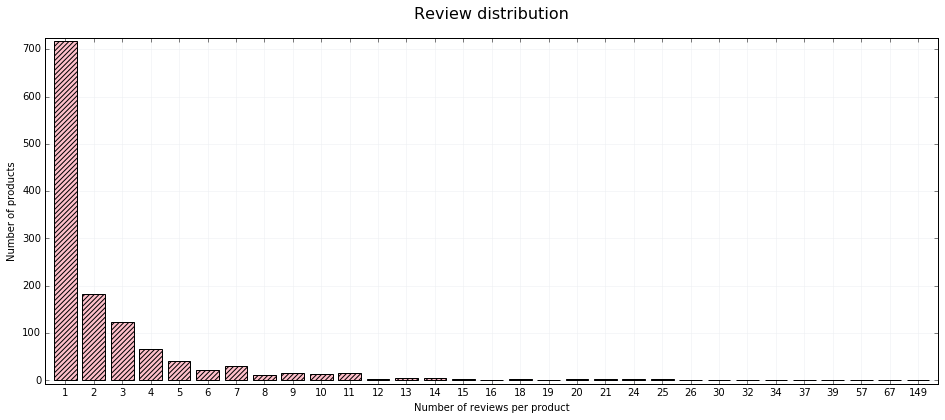

In [19]:
# get number of reviews per product
rws_counter = Counter(list(products_with_rws_count)).most_common()

# sort by reviews count (keys)
rws_counter = sorted(rws_counter, key=(lambda x:x[0]))

# and plot it
plot_sorted_counter(rws_counter, 'Number of reviews per product', 'Number of products', 
                    title='Review distribution')

#### Select reviews for analysis

I choose to select products with 10+ reviews for further analysis.

In [20]:
# get URLs of products with 10+ reviews
reviews_10plus = products_with_rws_count[products_with_rws_count >= 10].index
# DF with reviews of above products
reviews_10plus_df = reviews_df[reviews_df['product_url'].isin(reviews_10plus)]

print ('Number of products with 10+ reviews:  ' + str(len(reviews_10plus)))
print ('Number of reviews for these products: ' + str(len(reviews_10plus_df)))

Number of products with 10+ reviews:  69
Number of reviews for these products: 1289


- - - 

## Phrases in reviews

Based on reviews, it'd be nice to extract some useful information for potential customers. I'd    
like to find important phrases that somehow describe the product or experience with the seller.

In [21]:
import nltk
import seaborn as sns

I defined few grammar rules for extraction of useful phrases from the text.    
The rules use parts of speech (POS) tags and include the folowing patterns:

 - ```{<JJ>+<NN|NNS>}```  -
 - ```{<RB>*<JJ>+<VBN>}```-
 - ```{<RB>+<VBG>}```     -
 - ```{<RB>+<VBN|VBD>}``` -     
 - ```{<VBG><DT>*<NN|NNS>}```      - 
 - ```{<NN><VBD|VB>*<RB>+<JJ>*}``` - 
 - ```{<S><JJ>}```   - 
 - ```{<VBG><RB>}``` -

In [22]:
def extract_phrases(sentence):
    
    grammar = r"""
    PHRASE: 
      {<JJ>+<NN|NNS>}
      {<RB>*<JJ>+<VBN>}
      {<RB>+<VBG>}
      {<RB>+<VBN|VBD>}      
      {<VBG><DT>*<NN|NNS>} 
      {<NN><VBD|VB>*<RB>+<JJ>*}  
      {<S><JJ>} 
      {<VBG><RB>}
    """
    cp = nltk.RegexpParser(grammar)
    words = nltk.word_tokenize(sentence)
    pos = nltk.pos_tag(words)

    p = cp.parse(pos)

    chunks = []
    for chunk in traverse(p):
        # add words under the condition that they are longer than 1 char.
        chunk_words = " ".join([w[0] for w in chunk if len(w[0]) > 1])
        if (len(chunk_words.strip()) > 0):
            chunks.append(chunk_words)

    return  chunks

In [23]:
def traverse(t):  
    words = []
    
    try:
        t.label()
    except AttributeError:
        return
    else:
        if t.label() == 'PHRASE': 
            return t.leaves() # or do something else
        else:
            for child in t:
                w = traverse(child)
                if (w != None):
                    words.append(w)
    
    return words
                

In [24]:
prod_phrases = []
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

for review_i in range(len(reviews_10plus_df)):
    
    review = reviews_10plus_df.iloc[review_i]
    product_url = review['product_url']
    review_text = review['text']
    review_id   = review['review_id']
    sentences = sent_detector.tokenize(review_text)
    
    phrases = []
    
    for s in sentences:
        phs = extract_phrases(s)
        if(len(phs) > 0):
            phrases.extend(phs)
    
    for p in phrases:
        prod_phrases.append({'product_url': product_url, 'phrase' : p, 'review_id': review_id})

prod_phrases_df = pd.DataFrame(prod_phrases)

In [25]:
# lowercase phrases
prod_phrases_df['phrase'] = prod_phrases_df['phrase'].apply(str.lower)

In [26]:
prod_phrases_df.head(3)

,phrase,product_url,review_id
0,nice figure,https://www.etsy.com/listing/112313118/greg-le...,2
1,cool item,https://www.etsy.com/listing/112313118/greg-le...,18
2,fantastic figure,https://www.etsy.com/listing/112313118/greg-le...,24


##### Most common phrases

In [27]:
Counter(prod_phrases_df['phrase']).most_common(12)

[('very well made', 26),
 ('good quality', 22),
 ('great product', 19),
 ('faux gold', 18),
 ('high quality', 15),
 ('beautifully made', 15),
 ('printable version', 14),
 ('beautiful bag', 13),
 ('fast shipping', 12),
 ('well made', 12),
 ('really well made', 12),
 ('roll up top', 11)]

- - -

## Sentiment polarity

Some of the phrases from reviews are positive and some are not. With sentiment analysis, we can give each phrase a numeric score   
ranging from **-1 (very negative)**, through **0 (neutral)** to **1 (very positive)**. Ideally, we'd like to train the analyzer on Etsy-specific data -   
for instance, *'fast shipping'* is a positive remark, yet it appears as neutral for the generic analyzer.

### Phrases

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [29]:
# init the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# assign polarity to phrases
prod_phrases_df['polarity'] = prod_phrases_df['phrase'].apply(lambda t: sid.polarity_scores(t)['compound'])  

Most **positive** phrases

In [30]:
prod_phrases_df.drop_duplicates('phrase').sort_values(['polarity'], ascending=False).head(5)

,phrase,product_url,review_id,polarity
494,super awesome,https://www.etsy.com/listing/76883212/thanksgi...,1767,0.8402
1443,great success,https://www.etsy.com/listing/88282099/bicycle-...,3258,0.8316
906,amazing beautiful,https://www.etsy.com/listing/114181351/waxed-c...,2552,0.8271
606,great care,https://www.etsy.com/listing/103960966/waxed-c...,2011,0.8074
1446,great gift,https://www.etsy.com/listing/88282099/bicycle-...,3263,0.7906


Most **negative** phrases

In [31]:
prod_phrases_df.drop_duplicates('phrase').sort_values(['polarity'], ascending=True).head(5)

,phrase,product_url,review_id,polarity
1439,horrible taste,https://www.etsy.com/listing/72559858/bicycle-...,3253,-0.5423
245,bad thing,https://www.etsy.com/listing/86786462/thanksgi...,1319,-0.5423
1501,wicked fast,https://www.etsy.com/listing/88282099/bicycle-...,3332,-0.5267
167,visible damage,https://www.etsy.com/listing/249479416/world-m...,925,-0.4939
1260,wrong item,https://www.etsy.com/listing/88282099/bicycle-...,3089,-0.4767


### Products

We can look at sentiment polarity from the product perspective - compute average polarity    
per product together with number of phrases (count) and minimal and maximal polarity.

In [32]:
# eliminate neutral phrases (some products have many and it ruins the mean)
polarized_prod_phrases_df = prod_phrases_df[prod_phrases_df['polarity'] != 0]

# compute mean, min and max polarity, number of phrases
prod_polarity = polarized_prod_phrases_df[polarized_prod_phrases_df['polarity'] != 0].groupby('product_url').agg(['mean', 'count', 'max', 'min'])['polarity']

In [33]:
# order products by mean polarity and return list of product_urls
prod_order = prod_polarity.sort_values('mean', ascending=False).index

**Most positive products**

In [34]:
prod_polarity.sort_values('mean', ascending=False).head(3)

,mean,count,max,min
product_url,,,,
https://www.etsy.com/listing/247896000/toronto-art-print-poster-wall-art,0.637175,4,0.7650,0.5719
https://www.etsy.com/listing/275673260/world-map-print-watercolor-travel-map,0.624900,2,0.6249,0.6249
https://www.etsy.com/listing/245904585/new-york-print-poster-wall-art-cityscape,0.616400,3,0.6249,0.5994


Take a look at the actual non-neutral phrases of the 3 most positive products.

In [35]:
positive_products = prod_order[:3]
for p in positive_products:
    print(p)
    print (polarized_prod_phrases_df[polarized_prod_phrases_df['product_url'] == p][['phrase', 'polarity']])

https://www.etsy.com/listing/247896000/toronto-art-print-poster-wall-art
               phrase  polarity
132    gorgeous print    0.6124
133  perfect addition    0.5719
197      perfect gift    0.7650
211  beautiful finish    0.5994
https://www.etsy.com/listing/275673260/world-map-print-watercolor-travel-map
           phrase  polarity
101   great print    0.6249
111  great poster    0.6249
https://www.etsy.com/listing/245904585/new-york-print-poster-wall-art-cityscape
               phrase  polarity
110   beautiful print    0.5994
131  awesome standard    0.6249
192      great poster    0.6249


**Most negative products**

In [36]:
prod_polarity.sort_values('mean', ascending=True).head(3)

,mean,count,max,min
product_url,,,,
https://www.etsy.com/listing/66731237/steam-punk-leather-cuff-with-2-gb-usb,-0.146300,3,0.1531,-0.2960
https://www.etsy.com/listing/249479416/world-map-watercolor-print-travel-map,0.134733,3,0.6249,-0.4939
https://www.etsy.com/listing/223302139/timber-wood-skin-money-clip-free-us,0.265875,4,0.5106,-0.2057


Non-neutral phrases of the 3 most negative products.

In [37]:
negative_products = prod_order[-3:]
for p in negative_products:
    print(p)
    print (polarized_prod_phrases_df[polarized_prod_phrases_df['product_url'] == p][['phrase', 'polarity']])

https://www.etsy.com/listing/223302139/timber-wood-skin-money-clip-free-us
                phrase  polarity
1584  much appreciated    0.5106
1585     good customer    0.4404
1586     not well made   -0.2057
1597       fresh cedar    0.3182
https://www.etsy.com/listing/249479416/world-map-watercolor-print-travel-map
                phrase  polarity
163      well packaged    0.2732
167     visible damage   -0.4939
213  great neutral art    0.6249
https://www.etsy.com/listing/66731237/steam-punk-leather-cuff-with-2-gb-usb
             phrase  polarity
1546      solid kid    0.1531
1550  missing piece   -0.2960
1552  missing piece   -0.2960


**Finding I** We see that except one product, all of them are in average on the positive side of the sentiment scale. The top-ranked products don't have any negative phrases in their reviews (```plarity.min >= 0```), while the bottom-ranked products have at least one negative phrase (```plarity.min < 0```).


**Finding II** Although majority of phrases extracted from reviews are neutral or positive, when a product receives a negative one such as *visible damage* or *missing piece*, it really brings it down.

#### Products and their review sentiment plot

The following boxplot nicely visualizes the distribution of phrase polarities for each product.      
The shorter the box is the higher agreement of polarities it represents (difference between most      
negative and most positive phrase is small). The products are ordered by their mean polarity from    
the most to the least positive ones.

```Red bar   : mean value```      
```Black bar : median```

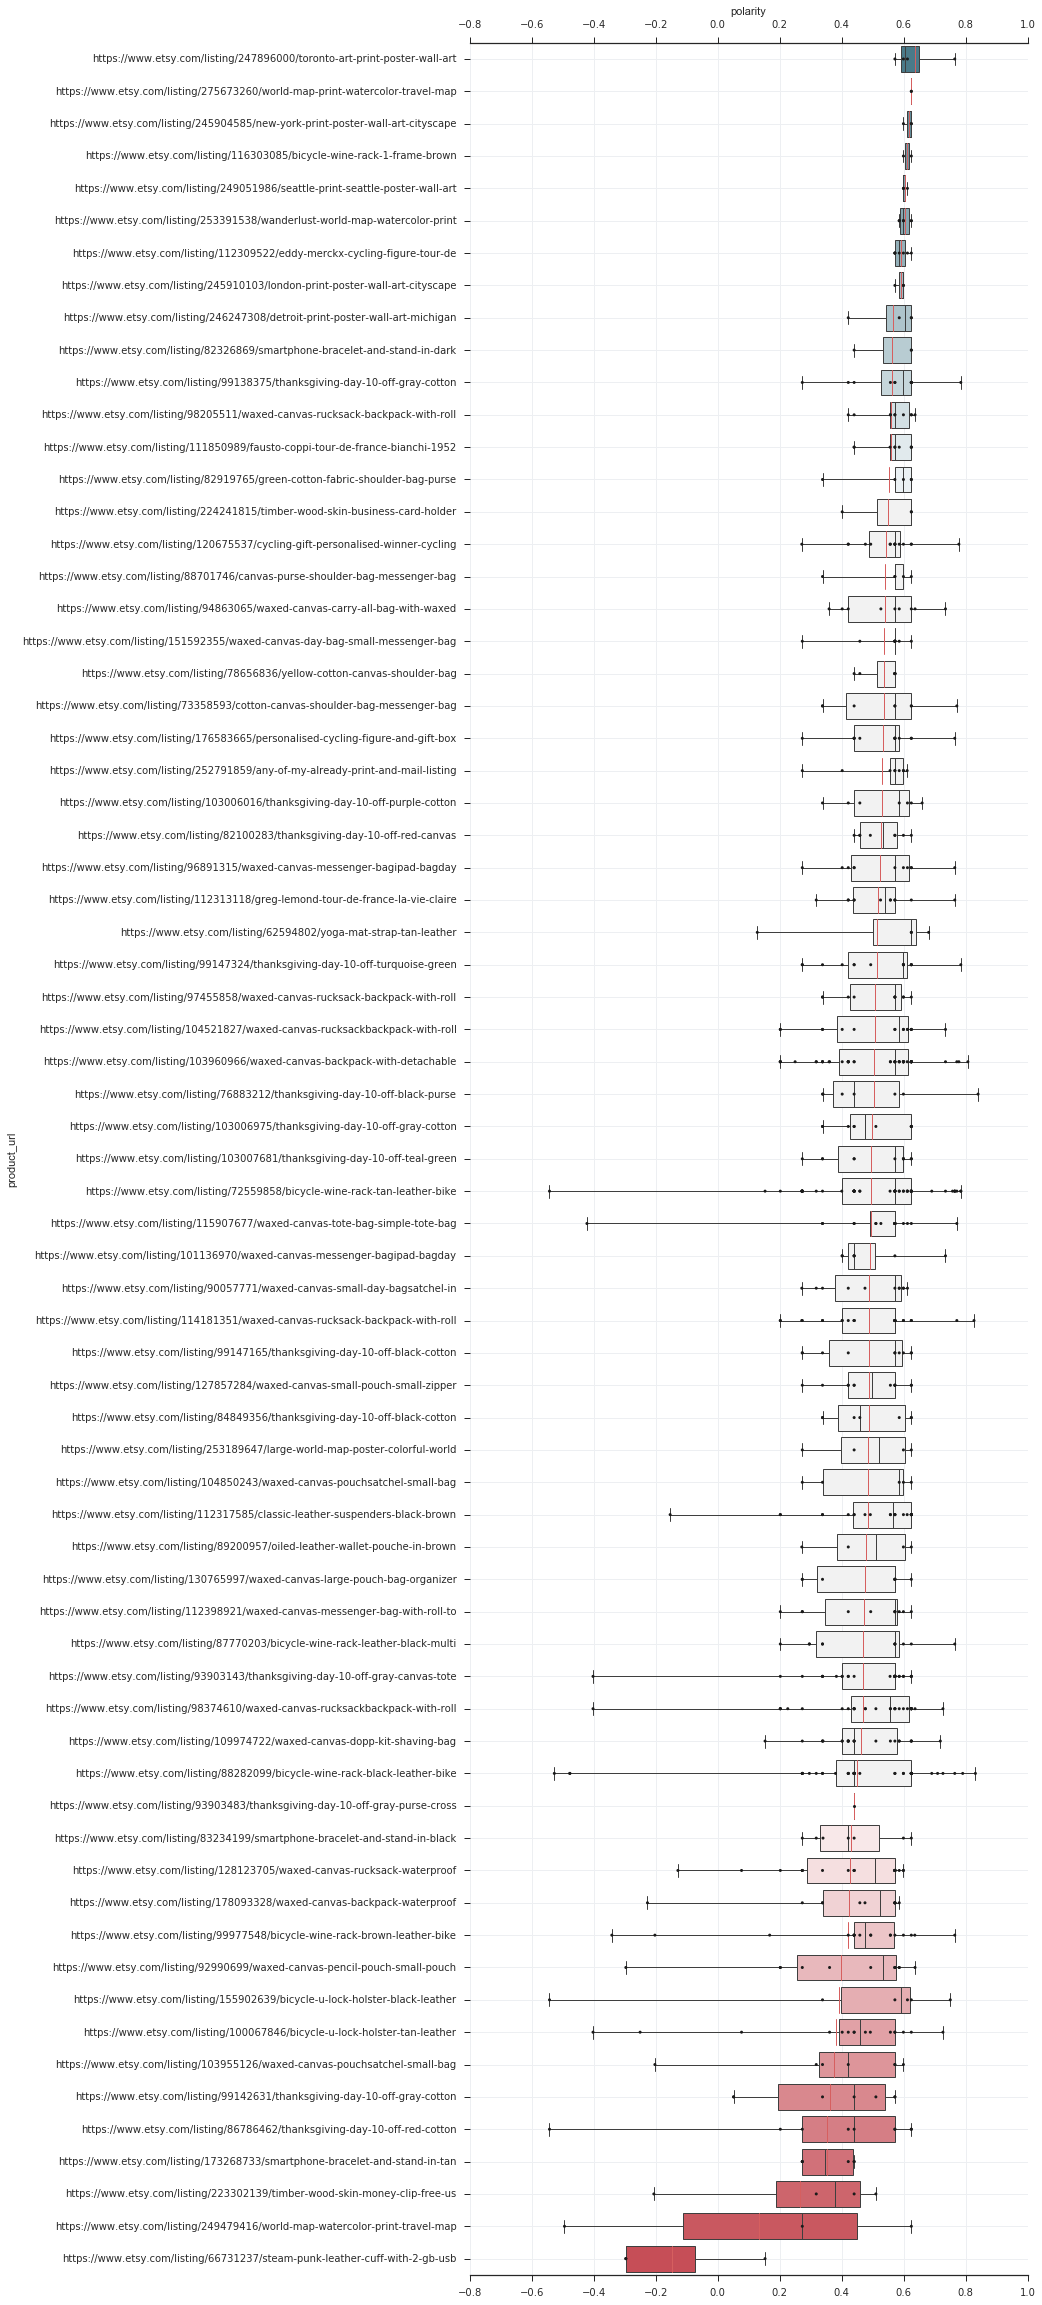

In [84]:
# DRAW BOXPLOT WITH PHRASES' POLARITIES PER PRODUCT 

# draw boxplot
plot_boxplot(polarized_prod_phrases_df, 'polarity', 'product_url', prod_order)

- - -

## Categories of phrases

It's common to ask customers of services like Etsy on their opinion on various qualities - price,    
shipping, communiction, etc. This information can be extracted from reviews and since we already     
have phrases and their sentiment polarity, we can even quantify user's satisfaction on these   
aspects - both by polarity and number of phrases.

The keywords and possibly also the categories should be retrieved automatically using a technique    
such as LDA or word2vec, but for the sake of this analysis I'll just define the vocabulary manually.

In [39]:
# keywords broken down into categories of interest
""" Categories: shipping, condition, communication, quality, price, gift, service, sizing, issues """ 
categories_keywords = {
    'shipping' :  ['shipment', 'shipping', 'postage', 'postal', 'package', 'packed', 'packet', 'wrap', 'order', 'delivery', 'delivered', 'received', 'fast', 'slow', 'speed', 'time', 'late', 'days', 'week', 'journey', 'tracking', 'turnaround', 'arrive'],
    'condition' : ['shape', 'condition', 'described', 'damage', 'item', 'piece', 'expected', 'matching'],
    'communication' : ['communication', 'contact', 'respond', 'response', 'complaint', 'contact', 'transaction', 'information', 'conversation', 'attention', 'message', 'help', 'email', 'e-mail', 'call'],
    'quality' :   ['quality', 'craft', 'made', 'material', 'work', 'look', 'detail', 'finish', 'texture', 'feel', 'taste', 'resolution', 'design', 'color', 'done'],
    'price' :     ['price', 'cheap', 'expensive', 'pay', 'paid', 'cheap', 'pricy'],
    'gift' :      ['gift', 'present', 'birthday', 'surprise', 'wish'],
    'service' :   ['service', 'seller', 'customize', 'customization', 'care'],
    'sizing' :    ['size', 'sizing'],
    'issues'  :   ['problem', 'fault', 'issue', 'drawback', 'complaint', 'issue', 'criticisms']
}

In [40]:
def find_key(input_dict, phrase):
    """
    Given a dictionary of categories and a phrase, 
    it returns a cat. name in case one of phrase words 
    is found within the category synonyms, otherwise
    returns 'None'.
    """
    #cat = None
    #for word in phrase.split(' '):
    #    q = next((k for k, v in input_dict.items() if word in v), None)
    #    if(q != None): cat = q
        
    #return cat
    for cat in input_dict.keys():
        for word in input_dict[cat]:
            if(word in phrase):
                return cat
    return None

In [41]:
# assign phrase category (None if no category fits)
prod_phrases_df['phrase_category'] = prod_phrases_df['phrase'].apply(lambda x: find_key(categories_keywords, x))

An example of categories assigned to some phrases.

In [42]:
prod_phrases_df[['phrase', 'phrase_category']].sample(10)

,phrase,phrase_category
190,quick response,communication
1266,well made,quality
123,large world,None
1031,amazing toiletry,None
109,beautiful piece,condition
1458,nice gift,gift
131,awesome standard,None
1042,great seller,service
516,great color,quality
868,ever bought,None


#### Most frequent phrases per category

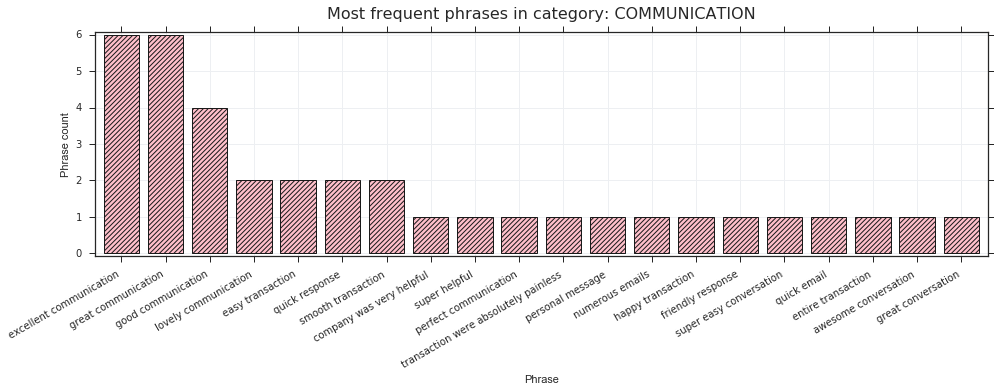

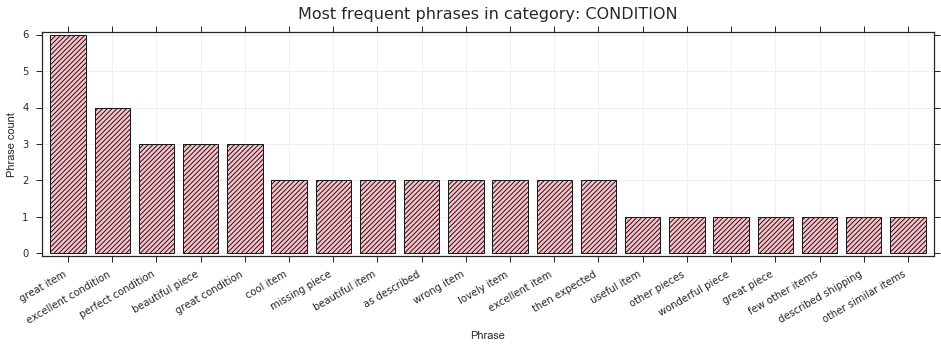

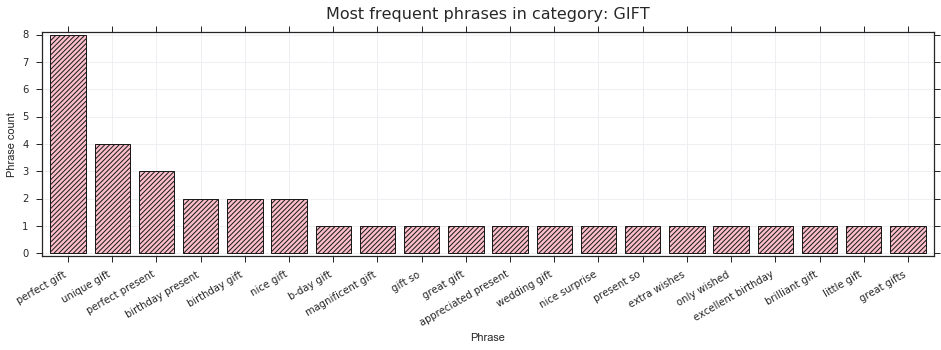

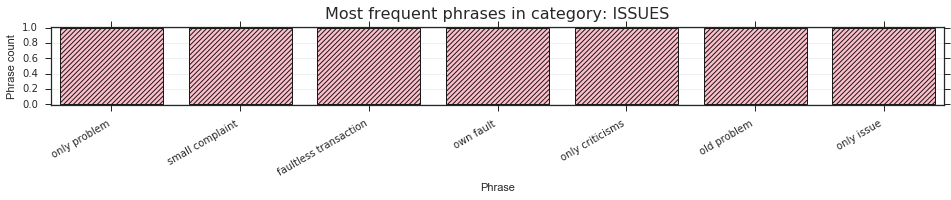

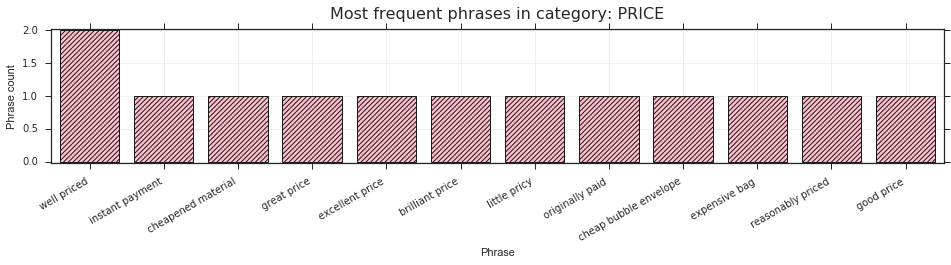

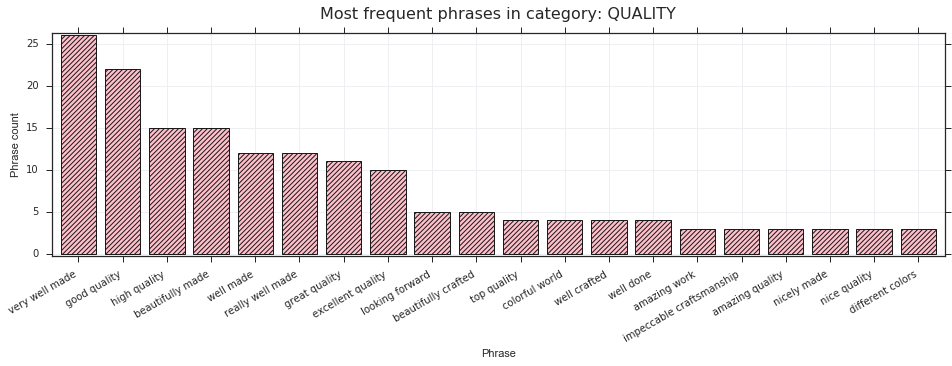

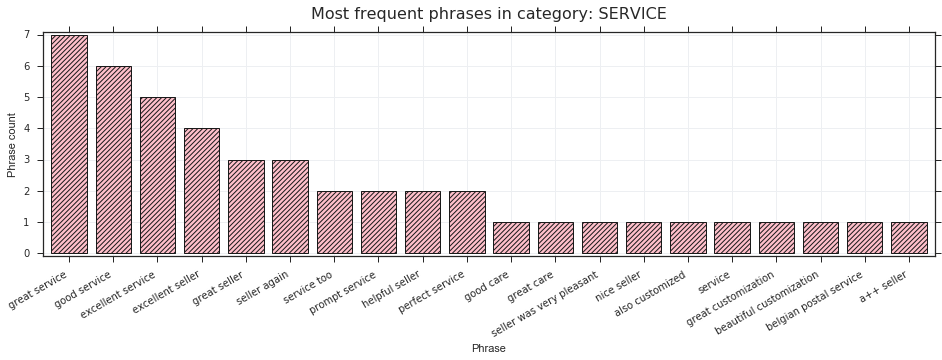

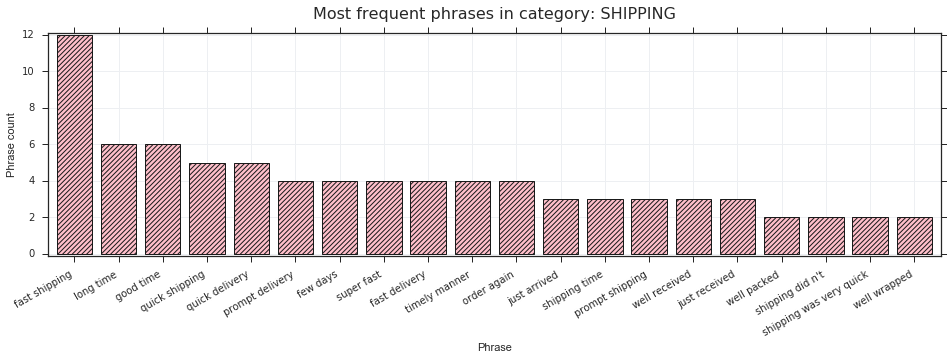

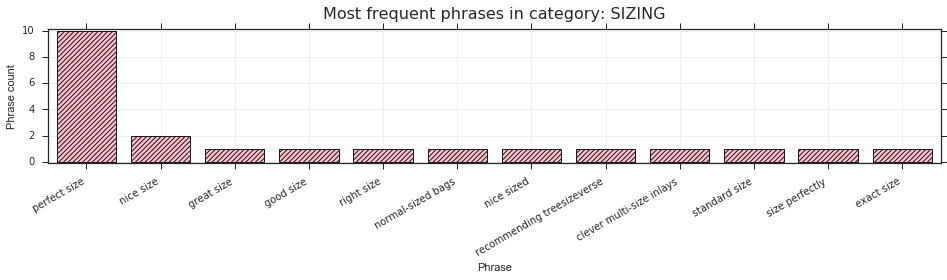

In [43]:
# phrases to display per category
TO_SHOW = 20

for ph_cat, group_cat in prod_phrases_df.groupby('phrase_category'):
    plot_sorted_counter(Counter(group_cat['phrase']).most_common(TO_SHOW), 
                        'Phrase', 
                        'Phrase count',
                        title = 'Most frequent phrases in category: ' + ph_cat.upper(), rotation=30)

#### Phrase snippets

In [46]:
# merge phrases with complete review details
phrases_details_df = pd.merge(reviews_10plus_df, prod_phrases_df, on='review_id', how='right')

In [47]:
phrases_details_df.sample(1)

,date,location,name,product_img,product_title,product_url_x,rating,shop,shop_img,text,date_norm,review_id,phrase,product_url_y,polarity,phrase_category
79,"Jan 15, 2013","Winchester, United Kingdom",Anonymous,https://img0.etsystatic.com/005/0/6811326/il_1...,Greg Lemond - La Vie Claire 1986 - Tour de Fra...,https://www.etsy.com/listing/112313118/greg-le...,5,DeskTopPeloton,https://img1.etsystatic.com/111/0/6811326/isla...,"Excellent figure, seller very accommodating",2013-01-15,303,excellent figure,https://www.etsy.com/listing/112313118/greg-le...,0.5719,None


In [48]:
def extract_snippet(text, phrase):
    for sentence in sent_detector.tokenize(text):
        if (phrase in sentence.lower()):
            return sentence
        
    return None

In [49]:
phrases_details_df['snippet'] = phrases_details_df.apply(lambda row: extract_snippet(row['text'], row['phrase']), axis=1)

In [58]:
phrases_details_df[['phrase', 'phrase_category', 'polarity', 'snippet']].sample(30)

,phrase,phrase_category,polarity,snippet
466,second purchase,None,0.0000,This is my second purchase and I couldn't be m...
1067,great integrity,None,0.7717,Fabulous quality and the craftsmanship shows g...
76,also came,None,0.0000,Also came at a brilliant price too.
1409,already came,None,0.0000,"And as a side note, I had asked the seller if ..."
586,someone else,None,0.0000,I nearly shed tears as it's a gift for someone...
123,large world,None,0.0000,"large world map poster, colorful world map pri..."
1495,really appreciated,None,0.5563,I really appreciated it!
1115,finished product,quality,0.0000,"I haven't actually seen the finished product, ..."
88,b-day gift,gift,0.4404,Husband loved it (b-day gift).
1030,good service,service,0.4404,"Very good service, fast shipping and I'm prett..."


## Sellers

To provide the user with a good picture about each seller, we can use the previously analyzed data       
and aggregate them  per each seller in the dataset. 

For each category we present a figure with:

 - bar plot on the left: **category distribution of phrases for a given shop**
    - categories: service, quality, shipping, condition, communication, sizing, gift, issues, price
    
    
 - middle plot: **distribution of phrases' polarity within given category**
    - x-axis: graph ranges from -1 (negative) to +1 (positive), 0 is neutral
    - y-axis: number of phrases with given sentiment polarity 
    - color: red for negative, green for positive phrases
     
     
 - text on the right: **top phrases per each category**
    - top phrases for given shop in given category
    - number in brackets is frequency of the phrase

A figure for each seller with:
	  (left) category distribution of phrases for a given shop, 
	(middle) distribution of phrases' polarity within given category, 
	 (right) top phrases per each category.


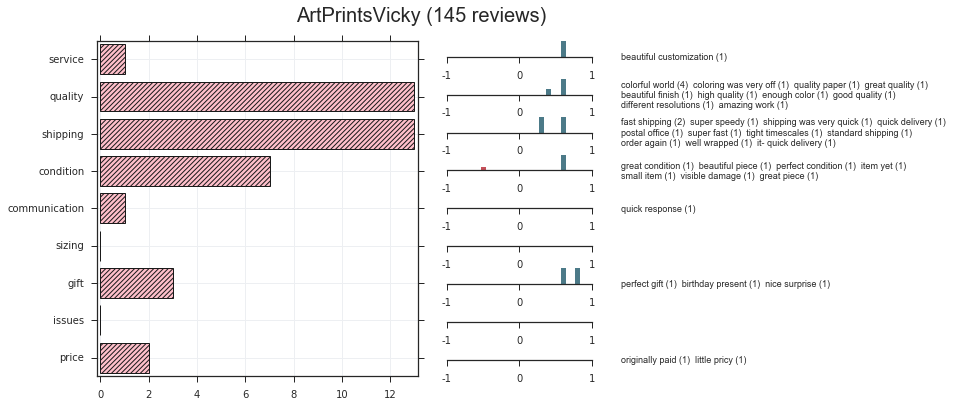

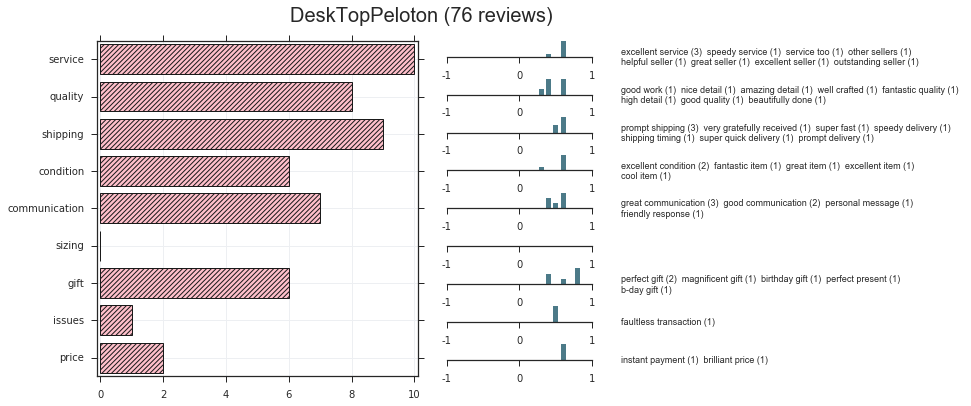

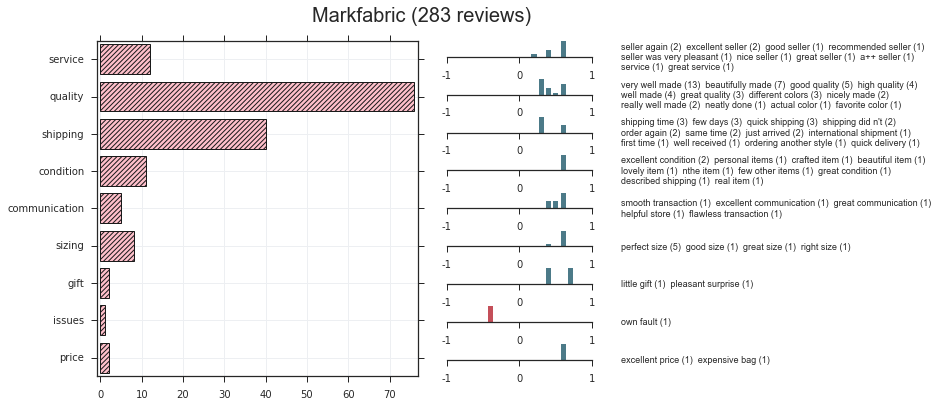

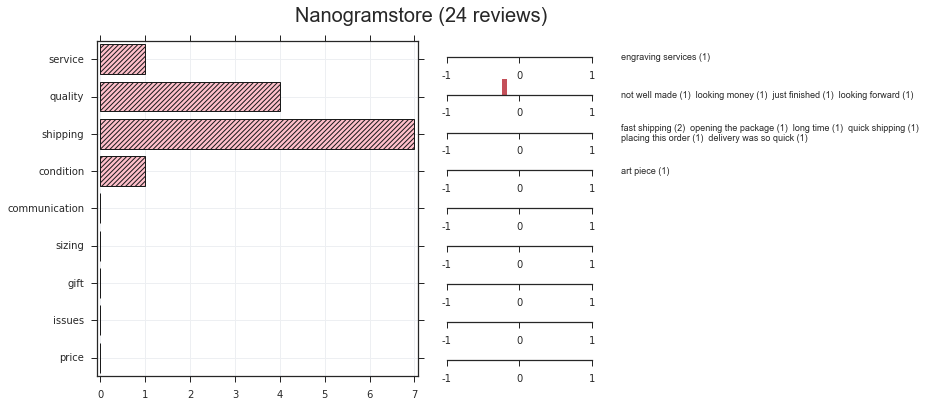

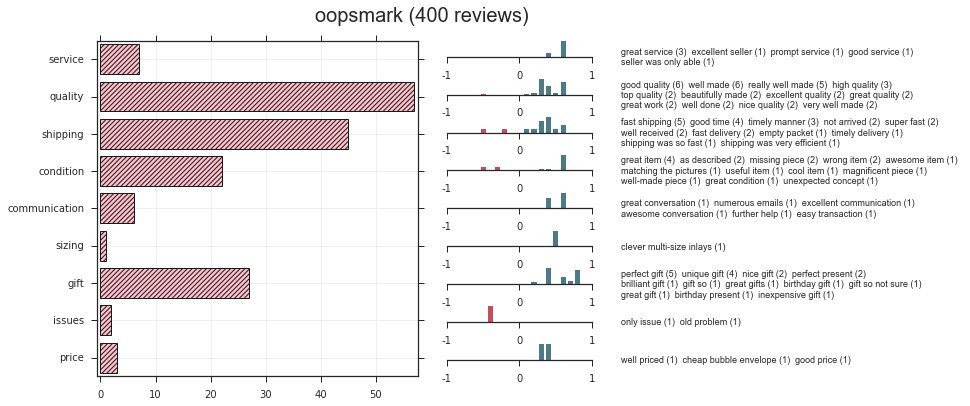

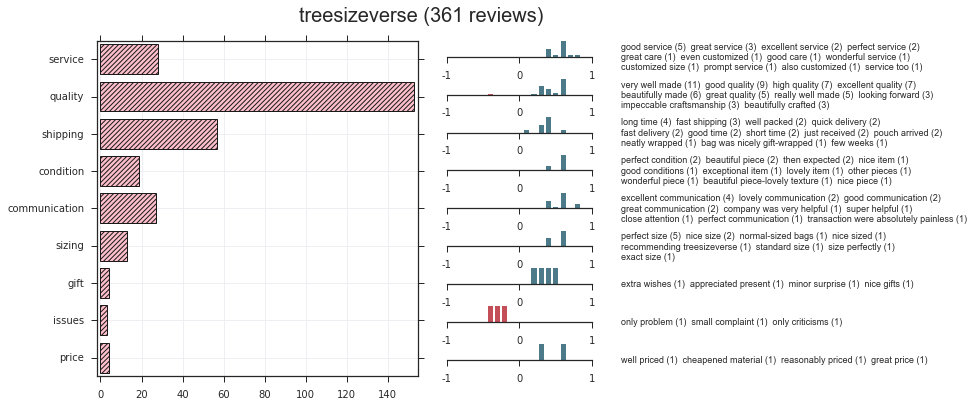

In [91]:
# define categories to display
CATEGORIES = ['service','quality','shipping','condition','communication','sizing','gift','issues','price']

# plot dimensions
PLOT_SIZE = (12, 6)

# print short desc.
print ('A figure for each seller with:')
print ('\t  (left) category distribution of phrases for a given shop, ')
print ('\t(middle) distribution of phrases\' polarity within given category, ')
print ('\t (right) top phrases per each category.')

# Process data for each shop
for shop, group_shop in phrases_details_df.groupby('shop'):
    
    # main plot size (cells)
    rows = len(CATEGORIES)
    cols = 4
    
    # dicts to store value for a shop
    cat_polarities = {}
    cat_values = {}
    cat_polar_values = {}
    cat_phrases = {}
    
    shop_reviews_no = len(reviews_10plus_df[reviews_10plus_df['shop'] == shop])
    phrase_groups = group_shop.groupby('phrase_category')
    
    # Prepare data for each category
    for ph_cat in CATEGORIES:
        
        try:
            cat_group = phrase_groups.get_group(ph_cat)
            cat_group_df = cat_group[cat_group['polarity'] != 0]
            p_tmp = list(cat_group_df['polarity'].apply(lambda x: round(x, 1)))
            
            cat_polarities[ph_cat] = p_tmp
            cat_values[ph_cat] = len(cat_group)
            cat_polar_values[ph_cat] = len(cat_group_df)            
            cat_phrases[ph_cat] = list(Counter(cat_group['phrase']).most_common())

        except:
            # categories with no data
            cat_polarities[ph_cat] = []
            cat_values[ph_cat] = 0
            cat_polar_values[ph_cat] = 0
            
    
    # Define main PLOT figure
    fig = plt.figure(figsize=PLOT_SIZE) 
    fig.suptitle(shop + ' (' + str(shop_reviews_no) + ' reviews)', size=20)
    gs = gridspec.GridSpec(rows, cols)

    # PLOT: count of reviews per category
    gs_specs = gs[0:rows, 0:cols-2]    
    plot_cat_counter(CATEGORIES, [cat_values[cat] for cat in CATEGORIES], gs_specs)

    for row, ph_cat in enumerate(CATEGORIES):

        cntr = Counter(cat_polarities[ph_cat])

        # PLOT: polarity distribution
        gs_specs = gs[row:row+1, 2:3]
        plot_cat_polarity(cntr, gs_specs)
        
        # PLOT: most common phrases
        gs_specs = gs[row:row+1, 3:4]
        plot_text(cat_phrases.get(ph_cat, ''), gs_specs)

        

### Negative phrases per seller

It would be nice if the users had the possibility to filter reviews by category or their sentiment polarity.       
Although vast majority of phrases are positive or neutral (ignored in this study) there are some negative ones. Let's look at them.

In [83]:
negative_df = phrases_details_df[(phrases_details_df['polarity'] < 0) 
                                 & (phrases_details_df['phrase_category'].isnull() == False)]
for shop, group in negative_df.groupby('shop'):
    print(shop.upper() + '\n- - - - - - -')
    for row_i in range(len(group)):
        row = group.iloc[row_i]
        print('\tphrase:    ' + row['phrase'])
        print('\tsentence:  ' + row['snippet'])    
        print('\tpolarity:  ' + str(row['polarity']))
        print('\tcategory:  ' + str(row['phrase_category']))
        print()

ARTPRINTSVICKY
- - - - - - -
	phrase:    visible damage
	sentence:  Should be packaged in an additional bag or something within the tube to avoid visible damage.
	polarity:  -0.4939
	category:  condition

MARKFABRIC
- - - - - - -
	phrase:    own fault
	sentence:  Though a little smaller than I was imagining (my own fault for not reading dimensions more carefully) this tote is great!
	polarity:  -0.4019
	category:  issues

NANOGRAMSTORE
- - - - - - -
	phrase:    not well made
	sentence:  Item received was not well made.
	polarity:  -0.2057
	category:  quality

OOPSMARK
- - - - - - -
	phrase:    old problem
	sentence:  Solves the age old problem of lugging your ulock around with style. 
	polarity:  -0.4019
	category:  issues

	phrase:    wrong item
	sentence:  They send me the wrong item and as I needed it for a birthday that was an issue.
	polarity:  -0.4767
	category:  condition

	phrase:    wrong item
	sentence:  They send me the wrong item and as I needed it for a birthday that was a